<a href="https://colab.research.google.com/github/enriquemx1/Forecasts/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import logging
import pickle
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import(
    plot_acf,
    plot_pacf
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [13]:
# Cargar Dataset
df_raw = pd.read_csv("../history/HISTORY.csv")
# Ver la información general del dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    39 non-null     object
 1   CALLS   39 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 756.0+ bytes


In [14]:
# Proteger la base de datos
df_baking = df_raw.copy()
df_baking.sample(10)


,DATE,CALLS
5,6/1/2022,98271
19,8/1/2023,91059
25,2/1/2024,74768
20,9/1/2023,93437
1,2/1/2022,85826
21,10/1/2023,95768
26,3/1/2024,85131
34,11/1/2024,73452
15,4/1/2023,89234
35,12/1/2024,63334


In [15]:
# Convertir los nombres de las columnas a minúscula
df_baking.columns = df_baking.columns.str.lower()
df_baking.sample(10,random_state=2025)

,date,calls
6,7/1/2022,102626
29,6/1/2024,103195
36,1/1/2025,53570
27,4/1/2024,87690
33,10/1/2024,77571
32,9/1/2024,74689
21,10/1/2023,95768
2,3/1/2022,96769
17,6/1/2023,96440
26,3/1/2024,85131


In [16]:
#eliminar aht para trabajar solo con llamadas
df_baking = df_baking.drop(columns=['aht'], errors='ignore')
df_baking.sample(10)

,date,calls
14,3/1/2023,90885
19,8/1/2023,91059
30,7/1/2024,80995
25,2/1/2024,74768
35,12/1/2024,63334
28,5/1/2024,86645
32,9/1/2024,74689
13,2/1/2023,75578
20,9/1/2023,93437
24,1/1/2024,74449


In [17]:
# Convertir la columna 'date' a formato datetime especificando el formato
# Esto es porque mi fecha viene en formato dd/mm/yyyy
df_baking['date'] = pd.to_datetime(df_baking['date'], dayfirst=True)

# Verificar el cambio
df_baking.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    39 non-null     datetime64[ns]
 1   calls   39 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 756.0 bytes


In [ ]:
# Si hubiera venido una col con mes y una col con año debería hacer:
    #vamos a convertir  el contenido de month a formato de mes
    # df_baking = df_raw.copy()
    # df_baking['month'] = pd.to_datetime(df_baking['mont'], format="%b").dt.month
    # .dt extrae cualquier valor que sea fecha, en este caso mes
# Luego concatenamos el año
    #creamos una col llamada date
    #le metemos 'year' y 'month'
    #como no tenemos day le forzamos el 1 con .assign(day=1)
    # df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
# Volvemos la fecha como indice
    #df_baking = df_baking.set_index('date')

In [18]:
# Hay que volver la fecha index
df_baking = df_baking.set_index('date')
df_baking.sample(5)

,calls
date,
2024-01-12,63334
2023-01-01,77620
2025-01-02,51844
2022-01-09,95256
2023-01-06,96440


In [23]:
# Definir índices para dividir los datos
train_size = int(0.8 * len(df_baking))  # 80% de los datos para entrenamiento

# Crear los DataFrames de entrenamiento y prueba
df_train = df_baking.iloc[:train_size]  # Desde el inicio hasta el 80% del dataset
df_test = df_baking.iloc[train_size:]   # Desde el 80% hasta el final del dataset

# Verificar la división
print(f"Datos de entrenamiento: {len(df_train)} renglones")
print(f"Datos de prueba: {len(df_test)} renglones")
print(f"Total de datos: {len(df_baking)} renglones")

# Mostrar información de los datos de entrenamiento
df_train.info()


Datos de entrenamiento: 31 renglones
Datos de prueba: 8 renglones
Total de datos: 39 renglones
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2022-01-01 to 2024-01-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   calls   31 non-null     int64
dtypes: int64(1)
memory usage: 496.0 bytes


In [24]:
# Generar estadísticas descriptivas 
df_train['calls'].describe().T.round(0)


count        31.0
mean      89783.0
std       10186.0
min       62098.0
25%       83336.0
50%       90885.0
75%       97592.0
max      103195.0
Name: calls, dtype: float64

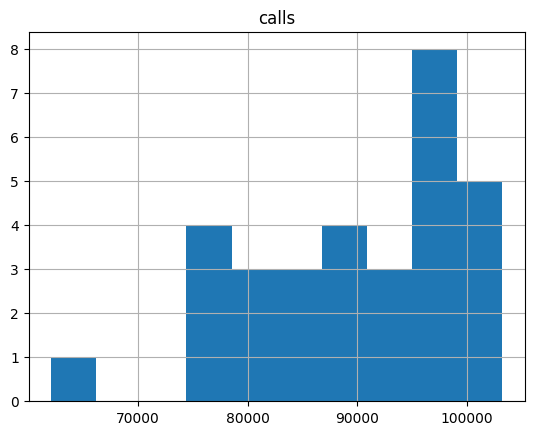

In [25]:
# Crear un histograma para 
df_train.hist()
plt.show()

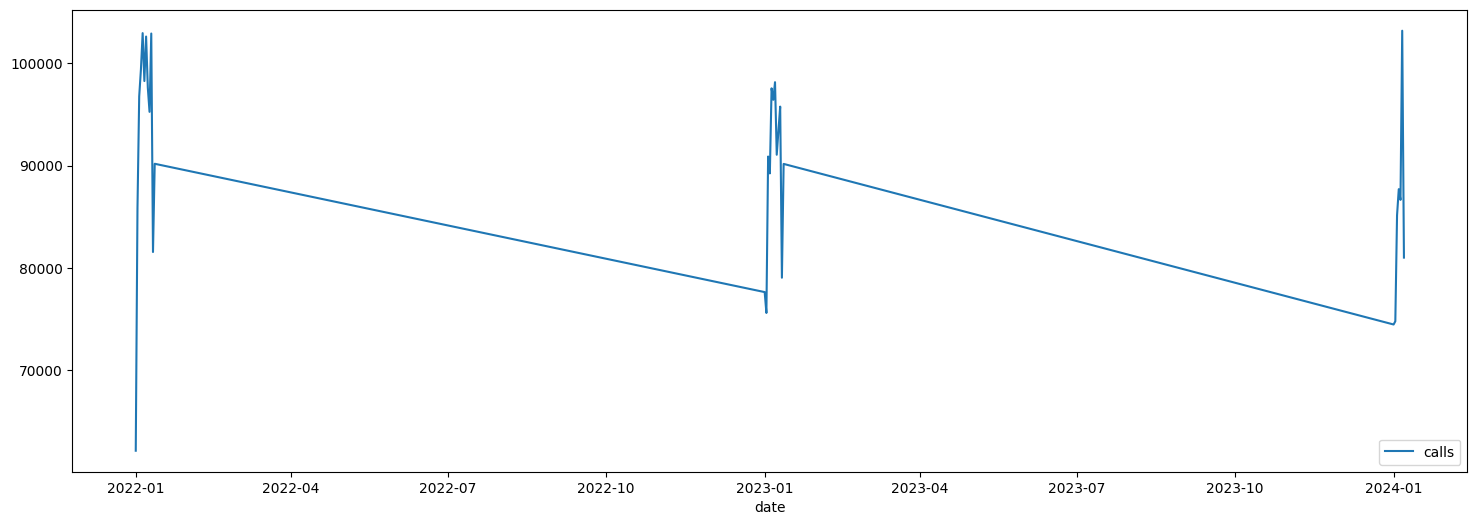

In [52]:
# Tendencia 
plt.figure(figsize=(18, 6))
sns.lineplot(df_train)
plt.show()

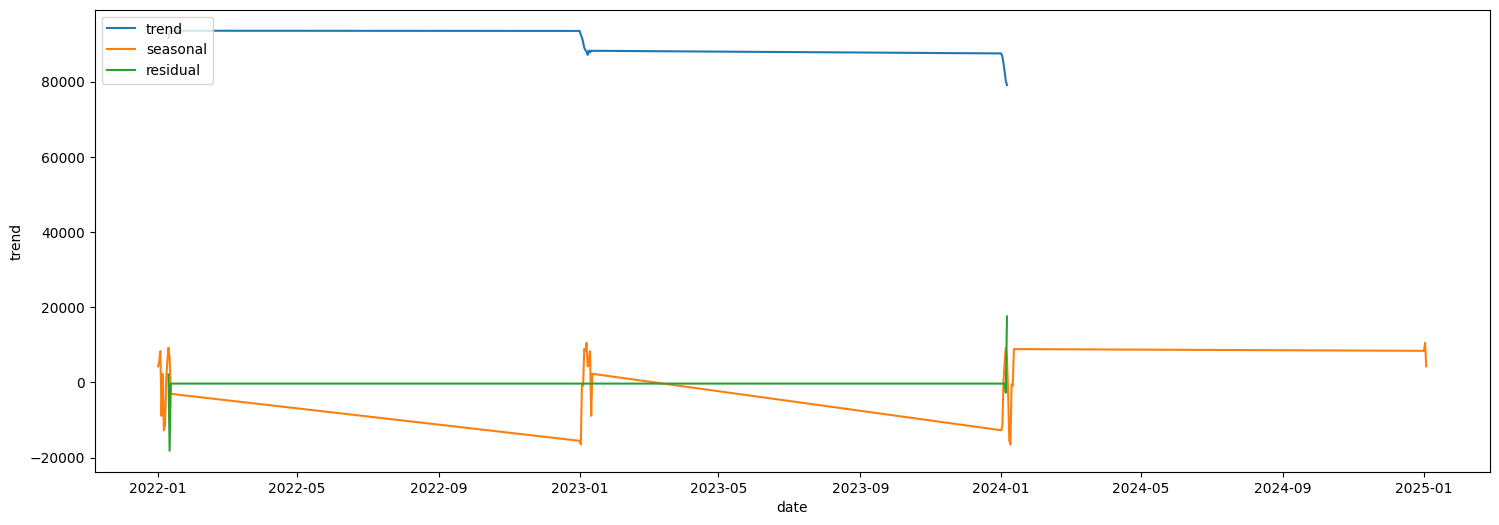

In [50]:
# Calculamos el número de observaciones y el periodo
n_observaciones = len(df_baking)  # Número total de observaciones
periodo = math.floor(n_observaciones / 2)  # Mitad del número de observaciones, redondeado hacia abajo

# Descomposición estacional del tiempo
plt.figure(figsize=(18, 6))
decomposition = seasonal_decompose(df_baking['calls'], period=periodo)  # Usamos el periodo calculado
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficamos los componentes
sns.lineplot(data=trend, label='trend')
sns.lineplot(data=seasonal, label='seasonal')
sns.lineplot(data=residual, label='residual')
plt.legend(loc='upper left')
plt.show()



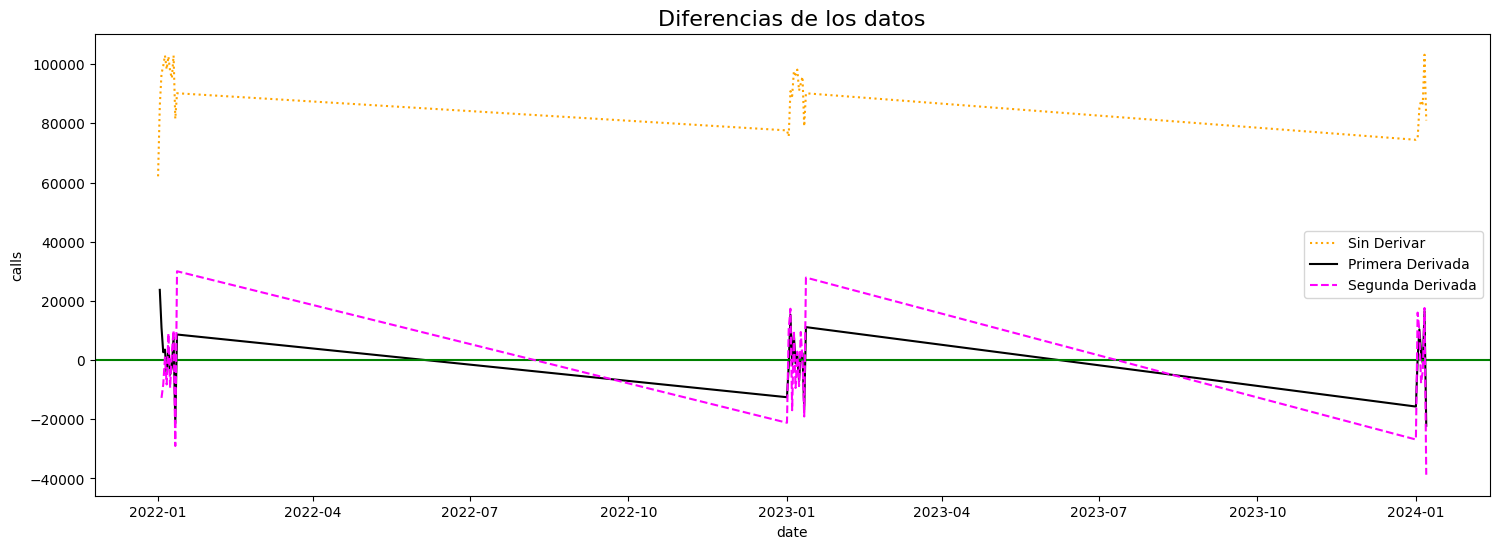

In [51]:
plt.figure(figsize=(18, 6))
# Generar el orden de derivada para volver estacionarios los datos (estacionario = los datos no tienen tendencia)

# Debemos quitar el ruido para que los datos oscilen de manera horizontal

# Sin derivadar
sns.lineplot(df_train['calls'], color='orange', linestyle=':', label='Sin Derivar')

# Primera derivada
sns.lineplot(df_train['calls'].diff(), color='black', label='Primera Derivada')

# Línea base
plt.axhline(0, color='green')

# Segunda Derivada
sns.lineplot(df_train['calls'].diff().diff(), color='magenta', linestyle='--', label='Segunda Derivada')

# Título
plt.title('Diferencias de los datos', fontsize=16)
plt.legend()
plt.show()




In [49]:
from statsmodels.tsa.stattools import adfuller

# Inicializar la variable d
d = 0  # Número de derivadas realizadas para estacionarizar

# Prueba ADF sin diferenciación
ad_fuller = adfuller(df_train['calls'], autolag='AIC')  # Selección de lags por AIC
print(f"Estadístico ADF (sin diferenciar): {ad_fuller[0]:.2f}")
print(f"p-value: {ad_fuller[1]:.2f}")
print(f"Número de lags seleccionados: {ad_fuller[2]}")

# Verificar si el p-value es mayor a 0.05
if ad_fuller[1] > 0.05:
    print("El p-value es alto, los datos no son estacionarios. Aplicando primera diferencia...")
    d += 1  # Incrementamos d a 1 (primera diferencia)

    # Prueba ADF con primera diferencia
    ad_fuller_diff = adfuller(df_train['calls'].diff().dropna(), autolag='AIC')  # Selección de lags por AIC
    print(f"Estadístico ADF (primera diferencia): {ad_fuller_diff[0]:.5f}")
    print(f"p-value (primera diferencia): {ad_fuller_diff[1]:.5f}")
    print(f"Número de lags seleccionados (primera diferencia): {ad_fuller_diff[2]}")

    # Verificar si el p-value sigue siendo alto
    if ad_fuller_diff[1] > 0.05:
        print("El p-value sigue siendo alto, los datos aún no son estacionarios. Aplicando segunda diferencia...")
        d += 1  # Incrementamos d a 2 (segunda diferencia)

        # Prueba ADF con segunda diferencia
        ad_fuller_diff2 = adfuller(df_train['calls'].diff().diff().dropna(), autolag='AIC')  # Selección de lags por AIC
        print(f"Estadístico ADF (segunda diferencia): {ad_fuller_diff2[0]:.5f}")
        print(f"p-value (segunda diferencia): {ad_fuller_diff2[1]:.5f}")
        print(f"Número de lags seleccionados (segunda diferencia): {ad_fuller_diff2[2]}")

        if ad_fuller_diff2[1] > 0.05:
            print("El p-value sigue siendo alto incluso tras la segunda diferencia.")
        else:
            print("La segunda diferencia logró estacionarizar los datos.")
    else:
        print("La primera diferencia logró estacionarizar los datos.")
else:
    print("El p-value es bajo, los datos son estacionarios. No se requiere diferenciación.")

# Mostrar el valor final de d
print(f"El número final (d) de diferencias necesarias para estacionarizar los datos es: {d}")


Estadístico ADF (sin diferenciar): -0.30
p-value: 0.93
Número de lags seleccionados: 9
El p-value es alto, los datos no son estacionarios. Aplicando primera diferencia...
Estadístico ADF (primera diferencia): -5.26792
p-value (primera diferencia): 0.00001
Número de lags seleccionados (primera diferencia): 8
La primera diferencia logró estacionarizar los datos.
El número final (d) de diferencias necesarias para estacionarizar los datos es: 1


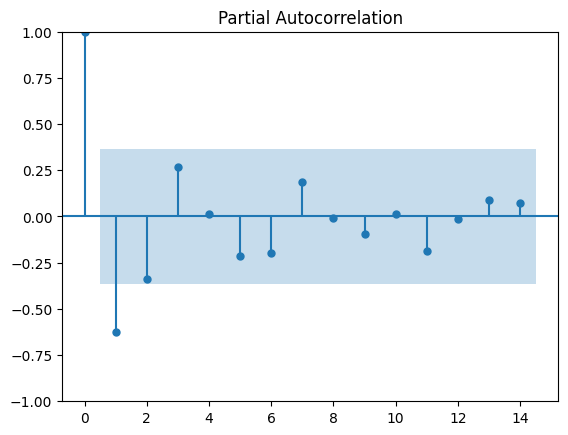

In [48]:
# p
# Término autoregresivo
plot_pacf(df_train['calls'].diff().diff().dropna())
plt.show()
# el valor de p se determina contando los puntos que caen afuera de la banda
# descartamos el primero, y contamos los siguientes
# porque la correlación entre si mismo es 1
# cada punto es el resultado de su relación con el punto anterior

In [ ]:
p=2


El valor de 'p' se ha establecido en: 2


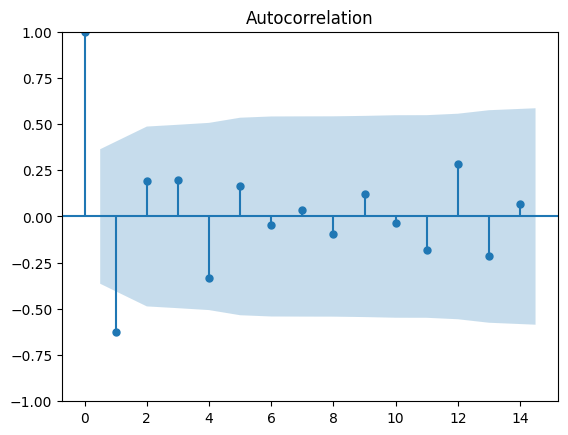

In [33]:
# q
# promedio movil
plot_acf(df_train['calls'].diff().diff().dropna())
plt.show()
# el valor de q se determina contando los puntos que caen afuera de la banda
# descartamos el primero, y contamos los siguientes
# porque la correlación entre si mismo es 1
# cada punto es el resultado de su relación con el punto anterior
# dejamos de contar en cuanto entre uno a la banda celeste

In [ ]:
q=2

El valor de 'q' se ha establecido en: 2


In [38]:
# machine learning
print(f"'d' (diferencial)             = {d}")
print(f"'p' (partial autocorrelation) = {p}")
print(f"'q' (moving average)          = {q}")

arima = ARIMA(df_train['calls'], order=(d,p,q))
ts_arima = arima.fit()

print(ts_arima.summary())

# P>|z| debe ser cercano a 0
# AIC (aicake number) entre más pequeño mejor pues hay menos pérdida de datos
# A veces se puede achicar el P value y no el AIC, es uno o el otro

'd' (diferencial)             = 1
'p' (partial autocorrelation) = 2
'q' (moving average)          = 2
                               SARIMAX Results                                
Dep. Variable:                  calls   No. Observations:                   31
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -315.755
Date:                Tue, 18 Mar 2025   AIC                            639.510
Time:                        17:24:28   BIC                            644.979
Sample:                             0   HQIC                           641.223
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2103      0.404     -0.521      0.602      -1.001       0.581
ma.L1         -0.6082      0.

/workspaces/Forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/Forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/Forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [47]:
# Definir el inicio de la predicción en el primer índice del conjunto de entrenamiento
inicio_prediccion = df_train.index[0]

# Calcular el fin de la predicción (6 meses después del primer índice de df_baking)
fin_prediccion = df_baking.index[0] + pd.DateOffset(months=6)

# Realizar la predicción utilizando ARIMA
y_hat = ts_arima.predict(start=inicio_prediccion, end=fin_prediccion)

# Mostrar los resultados de la predicción
print(y_hat)


KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

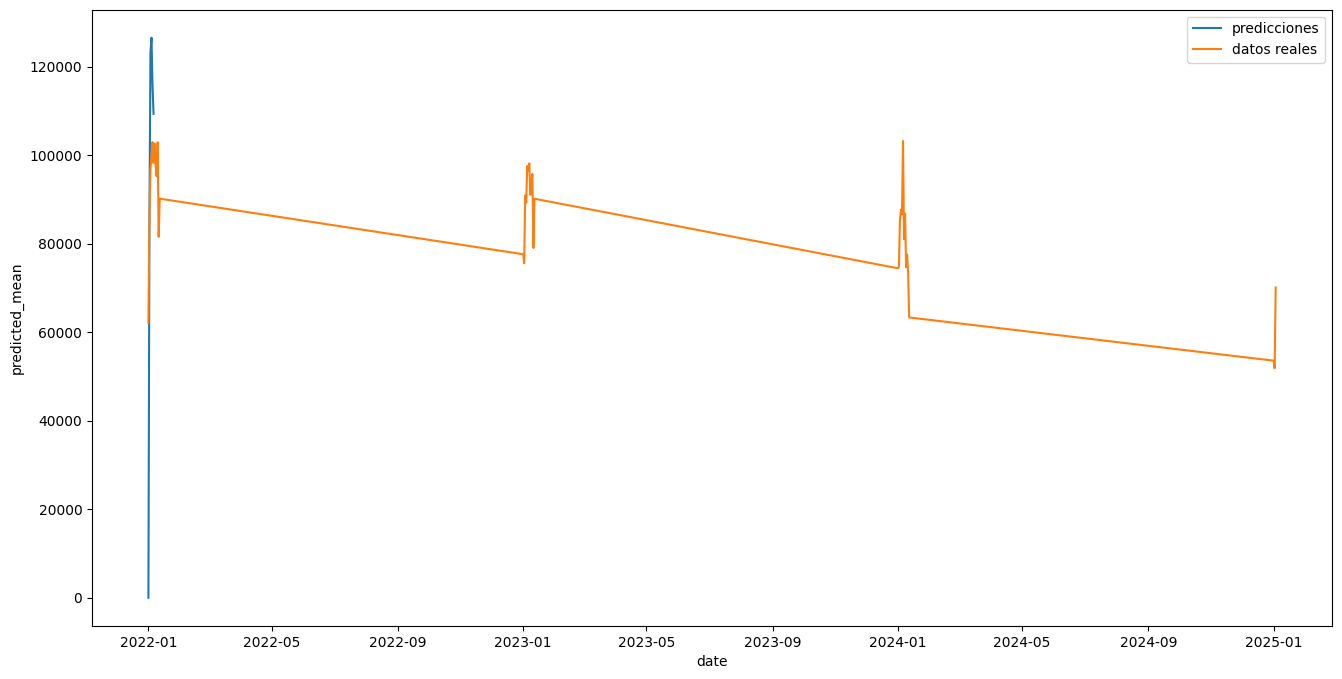

In [42]:
plt.figure(figsize=(16, 8))
sns.lineplot(y_hat, label='predicciones')
sns.lineplot(df_baking['calls'], label='datos reales')
plt.legend()
plt.show()


In [41]:
print(f'df_baking min date= {df_baking.index.min()}')
print(f'df_baking max date= {df_baking.index.max()}')
print(f'df_train min date= {df_train.index.min()}')
print(f'df_train max date= {df_train.index.max()}')
print(f'predicción min date= {y_hat.index.min()}')
print(f'predicción max date= {y_hat.index.max()}')

df_baking min date= 2022-01-01 00:00:00
df_baking max date= 2025-01-03 00:00:00
df_train min date= 2022-01-01 00:00:00
df_train max date= 2024-01-07 00:00:00
predicción min date= 2022-01-01 00:00:00
predicción max date= 2022-01-06 00:00:00
